In [1]:
# the ROOT framework 
import ROOT as rt
# load the larcv library
from larcv import larcv
# load matplotlib for image viewing
import matplotlib.pyplot as plt

Welcome to JupyROOT 6.14/02


In [2]:
# Load library containing SSNetDataLoader class
# returns 0 if successful
rt.gSystem.Load("../libssnetdata")

0

In [3]:
#  check if 'ssnet' namespace is available
# should see <class 'ROOT.ssnet'> is works
from ROOT import ssnet as ssnet # imports namespace from ROOT
print ssnet

<class 'ROOT.ssnet'>


In [4]:
# create instance of class with data
# should see: <ROOT.ssnet::SSNetDataLoader object at [random address]>
try:
    # clear out old loader
    del dataloader
except:
    pass
dataloader = ssnet.SSNetDataLoader()
print dataloader

<ROOT.ssnet::SSNetDataLoader object at 0x558cd5e029e0>


In [5]:
# load input file
inputfile = "../test_10k.root"
dataloader.setup( inputfile, 0, True )

    [NORMAL]  <ssnetio::prepare_input> Opening a file in READ mode: ../test_10k.root
    [NORMAL]  <ssnetio::initialize> Prepared input with 10000 entries...
    [NORMAL]  <SSNetDataLoader::setup> meta: Plane 65535 (cols,rows) = (256,256) ... pixel (width,height)=(0,0) ... Left Top (x,y)=(0,0) ... Right Bottom (x,y)=(0,0)
    [NORMAL]  <SSNetDataLoader::setup> meta: Plane 65535 (cols,rows) = (256,256) ... pixel (width,height)=(0,0) ... Left Top (x,y)=(0,0) ... Right Bottom (x,y)=(0,0)
    [NORMAL]  <SSNetDataLoader::setup> meta: Plane 65535 (cols,rows) = (256,256) ... pixel (width,height)=(0,0) ... Left Top (x,y)=(0,0) ... Right Bottom (x,y)=(0,0)
    [NORMAL]  <SSNetDataLoader::setup> Ready to return images with (row,col) size of (256,256)


Warning in <TClass::Init>: no dictionary for class larcv::EventClusterPixel2D is available
Warning in <TClass::Init>: no dictionary for class larcv::ClusterPixel2D is available
Warning in <TClass::Init>: no dictionary for class larcv::VoxelSetArray is available
Warning in <TClass::Init>: no dictionary for class larcv::EventParticle is available
Warning in <TClass::Init>: no dictionary for class larcv::ParticleSet is available
Warning in <TClass::Init>: no dictionary for class larcv::Particle is available
Warning in <TClass::Init>: no dictionary for class larcv::VoxelSet is available
Warning in <TClass::Init>: no dictionary for class larcv::Voxel is available


In [6]:
# import pytorch and uresnet network
import torch
import uresnet
from uresnet.models.uresnet_dense import UResNet
from uresnet.models.uresnet_dense import SegmentationLoss
from uresnet.flags import URESNET_FLAGS

In [12]:
# Configure network and load it
flags = URESNET_FLAGS()
flags.DATA_DIM = 2
flags.URESNET_FILTERS = 16
flags.URESNET_NUM_STRIDES = 4
flags.SPATIAL_SIZE = 256
flags.NUM_CLASS = 3 # bg, shower, track                                                                                                                                                                     
flags.LEARNING_RATE = 1.0e-3
flags.WEIGHT_DECAY = 1.0e-4
flags.BATCH_SIZE = 16
flags.checkpoint_file = "../checkpoint.run1.11000th.tar" # 16 features, images not conditioned

DEVICE = torch.device("cpu")

# MODEL
model = UResNet(flags).to(DEVICE)

device_map = {"cuda:0":"cpu",
              "cuda:1":"cpu"}
checkpoint = torch.load( flags.checkpoint_file, map_location=device_map )
model.load_state_dict( checkpoint["state"] )
model.eval()
#print model

UResNet(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.9, affine=True, track_running_stats=False)
    (2): ReLU()
  )
  (double_resnet): ModuleList(
    (0): DoubleResnet(
      (resnet1): ResNetModule(
        (shortcut): Sequential(
          (0): Conv2d(16, 32, kernel_size=(1, 1), stride=(2, 2))
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=False)
        )
        (residual1): Sequential(
          (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=False)
        )
        (residual2): Sequential(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=False)
        )
      )
      (resnet2): ResNetModule(
        (shortcut): Sequential(
          (0): Conv2d(32, 32, ker

63977


/usr/local/lib/python2.7/dist-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


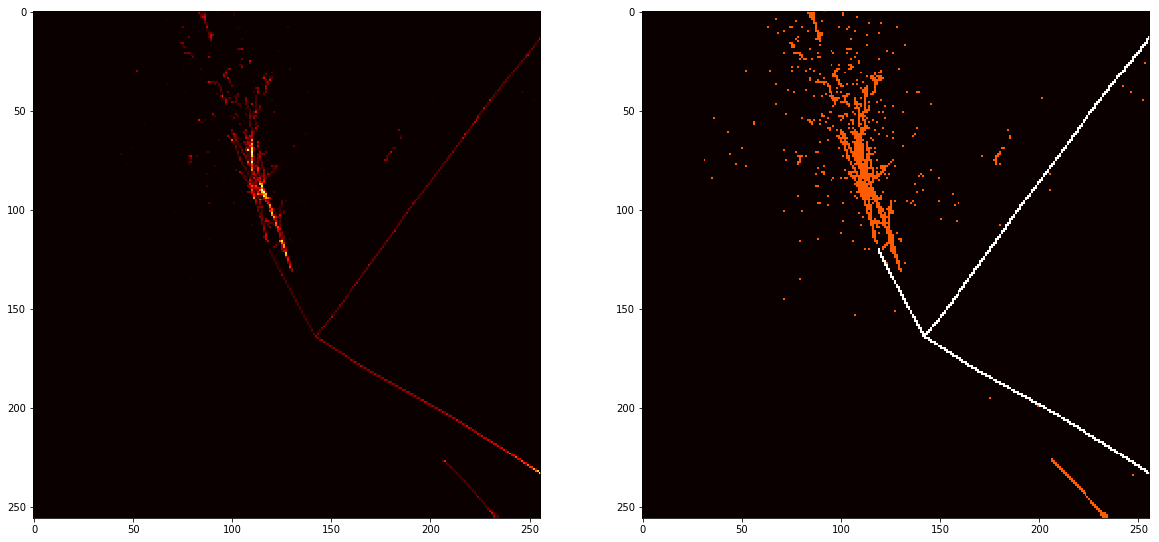

In [13]:
# get image and view image
datadict = dataloader.makeTrainingDataDict(1,2)
img = datadict['image_t']
print (img<10).sum()
img[img<10] = 0.0
img[img>1000] = 1000

fig, ax = plt.subplots(1,2,figsize=(20, 10))
ax[0].imshow(datadict['image_t'][0,0,:,:], cmap='hot', interpolation='nearest')
#ax[0].title('Pixel Values')


ax[1].imshow(datadict['label_t'][0,0,:,:], cmap='hot', interpolation='nearest')
#plt.imshow(datadict['label_t'][0,0,:,:], cmap='hot', interpolation='nearest')
#plt.title('Labels Values')
#plt.show()
fig.show()

In [24]:
# run network
image_t = torch.from_numpy( datadict['image_t'] )
with torch.no_grad():
    out_t = model.forward( image_t )
print out_t.shape
# use softmax
pred_t = torch.argmax( torch.nn.Softmax(dim=1)(out_t), dim=1, keepdim=True ).numpy()
print "pred-shape: ",pred_t.shape
# keep scores on interesting pixels
pred_t[ datadict['image_t']<10 ] = 0


torch.Size([1, 3, 256, 256])
pred-shape:  (1, 1, 256, 256)


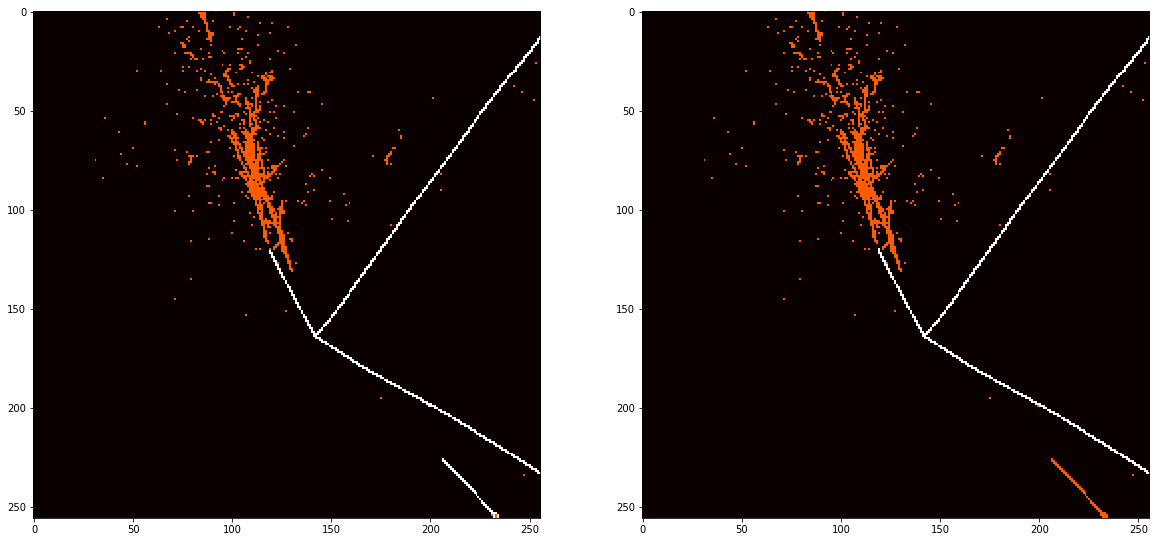

In [29]:
fig, ax = plt.subplots(1,2,figsize=(20, 10))

# LEFT: PREDICTION
ax[0].imshow(pred_t[0,0,:,:], cmap='hot', interpolation='nearest')


# RIGHT: TRUTH
ax[1].imshow(datadict['label_t'][0,0,:,:], cmap='hot', interpolation='nearest')
#plt.imshow(datadict['label_t'][0,0,:,:], cmap='hot', interpolation='nearest')
#plt.title('Labels Values')
#plt.show()
fig.show()

64655
torch.Size([1, 3, 256, 256])
pred-shape:  (1, 1, 256, 256)


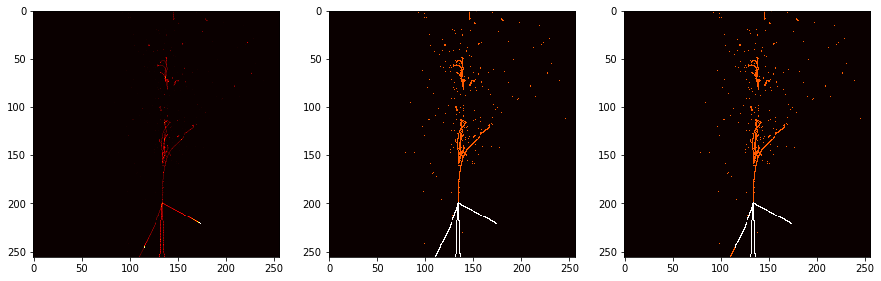

In [30]:
# ALL IN ONE

# GET DATA
datadict = dataloader.makeTrainingDataDict(1,2)
img = datadict['image_t']
print (img<10).sum()
img[img<10] = 0.0
img[img>1000] = 1000

# RUN NET
image_t = torch.from_numpy( img )
with torch.no_grad():
    out_t = model.forward( image_t )
print out_t.shape
# use softmax
pred_t = torch.argmax( torch.nn.Softmax(dim=1)(out_t), dim=1, keepdim=True ).numpy()
print "pred-shape: ",pred_t.shape
# keep scores on interesting pixels
pred_t[ img<10 ] = 0

# PLOT
fig, ax = plt.subplots(1,3,figsize=(15, 5))


# LEFT: INPUT
ax[0].imshow(img[0,0,:,:],cmap='hot', interpolation='nearest')

# CENTER: PREDICTION
ax[1].imshow(pred_t[0,0,:,:], cmap='hot', interpolation='nearest')


# RIGHT: TRUTH
ax[2].imshow(datadict['label_t'][0,0,:,:], cmap='hot', interpolation='nearest')


fig.show()
